In [111]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt 
from tqdm import tqdm

import torch
import torch.nn.functional as TF
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torchvision import transforms, utils

from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
from torchlib.transforms import functional as F
from torchlib.datasets.factory  import FactoryDataset
from torchlib.datasets.datasets import Dataset
from torchlib.datasets.fersynthetic  import SyntheticFaceDataset

from torchlib.attentionnet import AttentionNeuralNet, AttentionGMMNeuralNet
from torchlib.classnet import ClassNeuralNet

from aug import get_transforms_aug, get_transforms_det

In [112]:
pathnamemodel

'../out/attnet/feratt_attnet_ferattention_attloss_adam_ck_synthetic_filter128_dim32_bbpreactresnet_fold5_000/models/model_best.pth.tar'

In [113]:
project         = '../out/attnet/'
# projectname     = "feratt_attnet_ferattention_attloss_adam_ck_real_filter32_pool_size2_dim32_bbpreactresnet_fold5_000"
projectname     = "feratt_attnet_ferattention_attloss_adam_ck_synthetic_filter128_dim32_bbpreactresnet_fold5_000"
pathnamedataset = "~/.datasets/"  
pathnamemodel   = project + projectname + "/models/model_best.pth.tar"
pathproject     = os.path.join( project, projectname )
namedataset     = "ck"
breal           = 'real'
name_method      = 'attnet'
iteration       = 2000

fname = name_method
fnet = {
    'attnet': AttentionNeuralNet,
    'attgmmnet': AttentionGMMNeuralNet,
    'classnet': ClassNeuralNet,

}

no_cuda=False
parallel=False
gpu=0
seed=1
brepresentation=True
bclassification_test=True
brecover_test=False

imagesize=64
kfold = 5
nactores = 10
idenselect = np.arange(nactores) + kfold * nactores

# experiments
experiments = [ 
    { 'name': namedataset,        'subset': FactoryDataset.training,   'status': breal },
#     { 'name': namedataset,        'subset': FactoryDataset.validation, 'status': breal },
    # { 'name': namedataset+'dark', 'subset': FactoryDataset.training,   'real': False },
    # { 'name': namedataset+'dark', 'subset': FactoryDataset.validation, 'real': False },
    ]
    

In [114]:
dataset = SyntheticFaceDataset(
            data=FactoryDataset.factory(
                pathname=pathnamedataset, 
                name=namedataset, 
                subset=subset, 
                idenselect=idenselect,
                download=True 
                ),
            pathnameback='~/.datasets/coco', 
            ext='jpg',
            count=iteration,
            num_channels=3,
            iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
            transform_data=get_transforms_aug( imagesize ),
            transform_image=get_transforms_det( imagesize ),
            )


In [126]:
x_org, x_img, y_mask, meta = dataset[3]

In [127]:
y_lab = meta[0]
y_theta   = meta[1:].view(-1, 2, 3)

In [128]:
y_theta

tensor([[[ 1.1744,  0.4943,  0.6482],
         [-0.6002,  0.6829, -0.0178]]])

In [105]:
# Load models
print('>> Load model ...')
network = fnet[fname](
    patchproject=project,
    nameproject=projectname,
    no_cuda=no_cuda,
    parallel=parallel,
    seed=seed,
    gpu=gpu,
)

cudnn.benchmark = True

# load model
if network.load( pathnamemodel ) is not True:
    print('>>Error!!! load model')
    assert(False)


size_input = network.size_input
for i, experiment in enumerate(experiments):

    name_dataset = experiment['name']
    subset = experiment['subset']
    breal = experiment['status']
    dataset = []

    # load dataset 
    data=FactoryDataset.factory(
        pathname=pathnamedataset, 
        name=namedataset, 
        subset=subset, 
        idenselect=idenselect,
        download=True 
    )
    if breal == 'real':

        # real dataset 
        dataset = Dataset(    
            data=data,
            num_channels=3,
            transform=get_transforms_det( imagesize ),
            )

    else:

        # synthetic dataset 
        dataset = SyntheticFaceDataset(
            data=FactoryDataset.factory(
                pathname=pathnamedataset, 
                name=namedataset, 
                subset=subset, 
                idenselect=idenselect,
                download=True 
                ),
            pathnameback='~/.datasets/coco', 
            ext='jpg',
            count=iteration,
            num_channels=3,
            iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
            transform_data=get_transforms_aug( imagesize ),
            transform_image=get_transforms_det( imagesize ),
            )

    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=10 )

    print("\ndataset:", breal)
    print("Subset:", subset)
    print("Classes", dataloader.dataset.data.classes)
    print("size of data:", len(dataset))
    print("num of batches", len(dataloader))

    # representation
    if name_method == 'attgmmnet':
        # representation
        Y_labs, Y_lab_hats, Zs = network.representation(dataloader, breal)
        print(Y_lab_hats.shape, Zs.shape, Y_labs.shape)

    #     reppathname = os.path.join(pathproject, 'rep_{}_{}_{}.pth'.format(namedataset, subset,
    #                                                                          breal))
    #     torch.save({'Yh': Y_lab_hats, 'Z': Zs, 'Y': Y_labs}, reppathname)
    #     print('save representation ...', reppathname)

    else:
        Y_labs, Y_lab_hats= network.representation( dataloader, breal )
        print("Y_lab_hats shape: {}, y_labs shape: {}".format(Y_lab_hats.shape, Y_labs.shape))


>> Load model ...
=> loading checkpoint '../out/attnet/feratt_attnet_ferattention_attloss_adam_ck_synthetic_filter128_dim32_bbpreactresnet_fold5_000/models/model_best.pth.tar'
kw {'dim': 32, 'num_classes': 8, 'num_channels': 3, 'pretrained': False, 'num_filters': 128}
num filter in FERAttentionNet 128
pool size in FERAttentionNet 2


  0%|          | 0/6 [00:00<?, ?it/s]

=> loaded checkpoint for ferattention arch!

dataset: real
Subset: train
Classes ['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']
size of data: 323
num of batches 6


100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

Y_lab_hats shape: (323, 8), y_labs shape: (323,)


In [106]:
yhat = np.argmax( Y_lab_hats, axis=1 )
y    = Y_labs

In [40]:
success_idx = []
wrong_idx = []

for i in range(8):
    idx = np.where((y == i) & (y == yhat))[0][0]
    success_idx.append(idx)
    idx = np.where((y==i) & (y != yhat))[0][0]
    wrong_idx.append(idx)

In [41]:
success_idx

[2, 163, 249, 232, 30, 88, 141, 70]

In [42]:
wrong_idx

[0, 196, 264, 223, 32, 96, 140, 72]

In [71]:
def plot_gallery(images, titles, c, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'Predicted: %s\nActual:      %s' % (pred_name, true_name)



In [69]:
target_names = ['Neutral', 'Happiness', 'Surprise', 'Sadness', 'Anger', 'Disgust', 'Fear','Contempt']

In [97]:
np.random.seed(23)
curr = np.random.permutation(success_idx + wrong_idx)[:12]
print(curr)


[  2  32 249 163  30  88 264 223  72  70  96 140]


In [107]:
y_pred = yhat[curr]
y_test = y[curr]
X_test = []
y_label = []

for idx in curr:
    X_test.append(data[idx][0])
    y_label.append(data[idx][1])
    

In [108]:
np.all(np.array(y_label) == y_test)

True

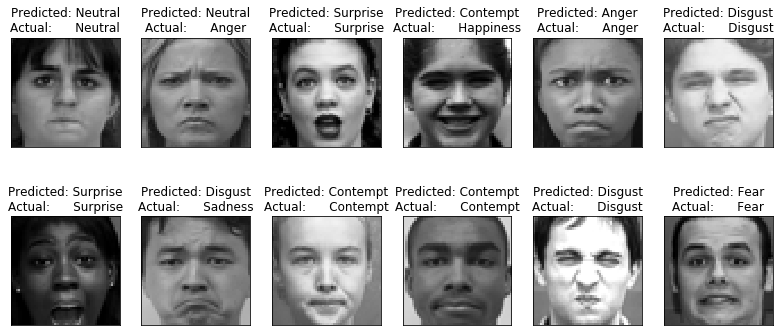

In [110]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
c, h, w = 3, 64, 64
plot_gallery(X_test, prediction_titles, c, h, w, n_row=2, n_col=6)
plt.savefig("ck_regonition_ferattn_improved.png", dpi=500, bbox_inches="tight")

In [101]:
data_store = []
curr_idx = '2  32 249 163  30  88 264 223  72  70  96 140'.split()
curr_idx = list(map(int, curr_idx))
for idx in curr_idx:
    data_store.append(data[idx])

In [102]:
# len(data_store)

12